#install package yang di butuhkan

In [1]:
!pip install earthengine-api

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.2 MB/s eta 0:00:00


In [3]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00


#Import package yang dibutuhkan

In [4]:
import ee
import sys
import folium
import numpy as np
import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import SparseRandomProjection
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, r2_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from matplotlib.colors import ListedColormap

##AUTENTIKASI KE GOOGLE EARTH ENGINE

In [5]:
# Authenticate Earth Engine account
ee.Authenticate()

In [6]:
# Initialize Earth Engine
ee.Initialize(project='ee-empirevirtual21')

#Memanggil full dataset 6 bulan

In [7]:
# Define the new geometry (replace with your own)
polygon_coordinates = [
    [106.72058244720908,-6.101990095458276],
     [106.72549621507564,-6.106897374044486],
      [106.72955175603566,-6.11240201553259],
       [106.7344656818434,-6.1161997638172645],
        [106.73832806282485,-6.103568979775495],
         [106.74158962898696,-6.102886226204333],
          [106.75197514229262,-6.1053612037603315],
           [106.75712498360122,-6.10527585989701],
            [106.76802548103774,-6.1057025790776285],
             [106.76751049690688,-6.097765546699356],
              [106.7439928882643,-6.099472445302006],
               [106.74073132210219,-6.098789686512929],
                [106.72837170296157,-6.089145625801187],
                 [106.7165270679518,-6.096997440555777],
                  [106.72058244720908,-6.101990095458276]
]

# Define the new geometry using the polygon coordinates
roi = ee.Geometry.Polygon(polygon_coordinates)

# Create an ImageCollection and apply filters
dataset = (ee.ImageCollection('LANDSAT/LC09/C02/T1')
           .filterBounds(roi)
           .filterDate('2022-04-01', '2022-11-01'));

area = ee.FeatureCollection(roi)

# Coba menampilkan data image hanya satu potret tanggal

In [42]:
# Initialize Earth Engine
ee.Initialize()

# Load a single image
single = ee.Image('LANDSAT/LC09/C02/T1/LC09_122064_20230423')

# Clip the image to the defined ROI
single_clipped = single.clip(roi)

# Apply atmospheric correction
corrected = ee.Algorithms.Landsat.simpleCloudScore(single_clipped)
trueColor53 = single_clipped.select(['B5', 'B3'])

# Calculate GCI
gci = trueColor53.expression('(B5 / B3) - 1', {
    'B5': trueColor53.select('B5'),
    'B3': trueColor53.select('B3')
})

# Normalize GCI to the range 0-1
normalized_gci = gci.unitScale(0, 1)

# Visualization parameters for GCI
gciVis = {
    'min': 0,
    'max': 1,
    'palette': ['#370617', '#d00000', '#eeef20', '#bfd200', '#38b000']
}

# Convert the Earth Engine image to a folium layer
ee_tile_layer = folium.TileLayer(
    tiles=gci.getMapId(gciVis)["tile_fetcher"].url_format,
    attr="Google Earth Engine",
    overlay=True,
    name='GCI'
)

# Create a folium map object
my_map = folium.Map(location=[-6.10, 106.73], zoom_start=14)

# Add the Earth Engine tile layer to the map
ee_tile_layer.add_to(my_map)

# Display the map
my_map


##Mengambil metadata dari citra

In [9]:
area.getInfo()

{'type': 'FeatureCollection',
 'columns': {'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[106.72058244720908, -6.101990095458276],
      [106.72549621507564, -6.106897374044486],
      [106.72955175603566, -6.11240201553259],
      [106.7344656818434, -6.1161997638172645],
      [106.73832806282485, -6.103568979775495],
      [106.74158962898696, -6.102886226204333],
      [106.75197514229262, -6.1053612037603315],
      [106.75712498360122, -6.10527585989701],
      [106.76802548103774, -6.1057025790776285],
      [106.76751049690688, -6.097765546699356],
      [106.7439928882643, -6.099472445302006],
      [106.74073132210219, -6.098789686512929],
      [106.72837170296157, -6.089145625801187],
      [106.7165270679518, -6.096997440555777],
      [106.72058244720908, -6.101990095458276]]]},
   'id': '0',
   'properties': {}}]}

#Inspect data sesuai lokasi yang diinginkan/ region of interest

In [12]:
info = dataset.getRegion(area, 500).getInfo()
print(info);

[['id', 'longitude', 'latitude', 'time', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA'], ['LC09_122064_20220404', 106.73108469445066, -6.110789720223045, 1649041201712, 10660, 9606, 8569, 7501, 9338, 6755, 5747, 8144, 5054, 23668, 22857, 21952, 0, 6846, 3125, 10976, 418], ['LC09_122064_20220420', 106.73108469445066, -6.110789720223045, 1650423591792, 12672, 11629, 10461, 9517, 11039, 8398, 7364, 10038, 6098, 19369, 18714, 55052, 0, 5780, 3296, 10958, 426], ['LC09_122064_20220506', 106.73108469445066, -6.110789720223045, 1651805987333, 10395, 9336, 8300, 7211, 9725, 6896, 5840, 7843, 5108, 23596, 22809, 21952, 0, 4984, 3534, 10996, 408], ['LC09_122064_20220522', 106.73108469445066, -6.110789720223045, 1653188375905, 37978, 37809, 36222, 36925, 38058, 12345, 13470, 36021, 12973, 7691, 8702, 55052, 0, 4490, 3783, 10979, 416], ['LC09_122064_20220607', 106.73108469445066, -6.110789720223045, 1654570777422, 15963, 1529

##Dataset diubah ke bentuk dataframe

In [13]:
# Reshape image collection
header = info[0]
data = np.array(info[1:])

In [14]:
# Convert the "data" array into a DataFrame
df_full = pd.DataFrame(data, columns=header)

# Now you have your data in a Pandas DataFrame
print(df_full)
# Export the DataFrame to an Excel file
df_full.to_excel('df_full.xlsx', index=False)

                       id           longitude            latitude  \
0    LC09_122064_20220404  106.73108469445066  -6.110789720223045   
1    LC09_122064_20220420  106.73108469445066  -6.110789720223045   
2    LC09_122064_20220506  106.73108469445066  -6.110789720223045   
3    LC09_122064_20220522  106.73108469445066  -6.110789720223045   
4    LC09_122064_20220607  106.73108469445066  -6.110789720223045   
..                    ...                 ...                 ...   
317  LC09_122064_20220826  106.73108469445066  -6.092823414540655   
318  LC09_122064_20220911  106.73108469445066  -6.092823414540655   
319  LC09_122064_20220927  106.73108469445066  -6.092823414540655   
320  LC09_122064_20221013  106.73108469445066  -6.092823414540655   
321  LC09_122064_20221029  106.73108469445066  -6.092823414540655   

              time     B1     B2     B3     B4     B5     B6  ...     B8  \
0    1649041201712  10660   9606   8569   7501   9338   6755  ...   8144   
1    1650423591792 

## Melihat informasi dari dataset

In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         322 non-null    object
 1   longitude  322 non-null    object
 2   latitude   322 non-null    object
 3   time       322 non-null    object
 4   B1         322 non-null    object
 5   B2         322 non-null    object
 6   B3         322 non-null    object
 7   B4         322 non-null    object
 8   B5         322 non-null    object
 9   B6         322 non-null    object
 10  B7         322 non-null    object
 11  B8         322 non-null    object
 12  B9         322 non-null    object
 13  B10        322 non-null    object
 14  B11        322 non-null    object
 15  QA_PIXEL   322 non-null    object
 16  QA_RADSAT  322 non-null    object
 17  SAA        322 non-null    object
 18  SZA        322 non-null    object
 19  VAA        322 non-null    object
 20  VZA        322 non-null    objec

##Ambil kolom time (Ubah menjadi satuan yang mudah dibaca)

In [16]:
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(float))]

In [17]:
time

[datetime.datetime(2022, 4, 4, 3, 0, 1, 712000),
 datetime.datetime(2022, 4, 20, 2, 59, 51, 792000),
 datetime.datetime(2022, 5, 6, 2, 59, 47, 333000),
 datetime.datetime(2022, 5, 22, 2, 59, 35, 905000),
 datetime.datetime(2022, 6, 7, 2, 59, 37, 422000),
 datetime.datetime(2022, 6, 23, 2, 59, 55, 386000),
 datetime.datetime(2022, 7, 9, 2, 59, 55, 461000),
 datetime.datetime(2022, 7, 25, 3, 0, 3, 614000),
 datetime.datetime(2022, 8, 10, 3, 0, 14, 863000),
 datetime.datetime(2022, 8, 26, 3, 0, 19, 284000),
 datetime.datetime(2022, 9, 11, 3, 0, 20, 65000),
 datetime.datetime(2022, 9, 27, 3, 0, 26, 773000),
 datetime.datetime(2022, 10, 13, 3, 0, 30, 536000),
 datetime.datetime(2022, 10, 29, 3, 0, 31, 805000),
 datetime.datetime(2022, 4, 4, 3, 0, 1, 712000),
 datetime.datetime(2022, 4, 20, 2, 59, 51, 792000),
 datetime.datetime(2022, 5, 6, 2, 59, 47, 333000),
 datetime.datetime(2022, 5, 22, 2, 59, 35, 905000),
 datetime.datetime(2022, 6, 7, 2, 59, 37, 422000),
 datetime.datetime(2022, 6, 23

B5 (Band 5):

Makna: B5 adalah kanal spektral di citra Landsat 8 yang mengukur intensitas radiasi elektromagnetik dalam wilayah inframerah dekat (NIR - Near Infrared).
Arti Tinggi Nilai: Nilai tinggi dalam kanal ini sering menunjukkan vegetasi yang sehat, karena tumbuhan yang aktif secara fotosintesis cenderung meresap radiasi NIR.
Arti Rendah Nilai: Nilai rendah bisa menunjukkan daerah non-vegetasi, seperti air atau tanah terbuka.
B3 (Band 3):

Makna: B3 adalah kanal spektral di citra Landsat 8 yang mengukur intensitas radiasi elektromagnetik dalam wilayah merah.
Arti Tinggi Nilai: Nilai tinggi dalam kanal ini dapat mengindikasikan keberadaan vegetasi yang subur, seperti hutan atau tanaman hijau yang padat.
Arti Rendah Nilai: Nilai rendah dapat menunjukkan daerah dengan sedikit atau tanpa vegetasi, seperti air atau permukaan tanah yang terbuka.
QA_PIXEL (Quality Assessment - Pixel):

Makna: QA_PIXEL adalah parameter yang menyediakan informasi tentang kualitas piksel dalam citra, termasuk informasi tentang kemungkinan kesalahan atau gangguan.
Arti Tinggi Nilai: Nilai tinggi dalam parameter ini dapat menunjukkan piksel yang memiliki kualitas yang baik dan dapat diandalkan untuk analisis.
Arti Rendah Nilai: Nilai rendah dapat menunjukkan piksel dengan potensi masalah, seperti awan, bayangan, atau gangguan lainnya.
SAA (Solar Azimuth Angle):

Makna: SAA adalah sudut azimut matahari yang mengukur arah matahari pada saat citra diambil.
Arti Tinggi Nilai: Nilai tinggi mengindikasikan bahwa citra diambil saat matahari berada di arah utara (di belakang pengambilan gambar).
Arti Rendah Nilai: Nilai rendah mengindikasikan bahwa citra diambil saat matahari berada di arah selatan (di depan pengambilan gambar).
SZA (Solar Zenith Angle):

Makna: SZA adalah sudut zenith matahari yang mengukur tingkat ketinggian matahari di langit pada saat citra diambil.
Arti Tinggi Nilai: Nilai tinggi mengindikasikan bahwa matahari lebih rendah di langit, seringkali di pagi atau petang.
Arti Rendah Nilai: Nilai rendah mengindikasikan bahwa matahari lebih tinggi di langit, seringkali di tengah hari.
VAA (View Azimuth Angle):

Makna: VAA adalah sudut azimut pandangan yang mengukur arah pandangan sensor di pesawat ruang angkasa pada saat citra diambil.
Arti Tinggi Nilai: Nilai tinggi menunjukkan arah pandangan sensor ke arah utara.
Arti Rendah Nilai: Nilai rendah menunjukkan arah pandangan sensor ke arah selatan.
VZA (View Zenith Angle):

Makna: VZA adalah sudut zenith pandangan yang mengukur tingkat ketinggian sensor di pesawat ruang angkasa pada saat citra diambil.
Arti Tinggi Nilai: Nilai tinggi mengindikasikan sensor yang lebih tinggi di langit.
Arti Rendah Nilai: Nilai rendah mengindikasikan sensor yang lebih rendah di langit.

## Memilih kolom yang digunakan untuk variabel penelitian

In [18]:
df = df_full[['B5','B3','QA_PIXEL','SAA','SZA','VAA','VZA']]

## Mengubah semua data menjadi tipe data float

In [19]:
# Assuming 'df' is your DataFrame
columns_to_convert = ['B5', 'B3', 'QA_PIXEL', 'SAA', 'SZA', 'VAA', 'VZA']

# Convert the selected columns to float
df[columns_to_convert] = df[columns_to_convert].astype(float)

<ipython-input-19-6d3cb334035d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_convert] = df[columns_to_convert].astype(float)


## Menyimpan dataset ke bentuk xlsx

In [20]:
# Specify the file path where you want to save the Excel file
file_path = 'Dataset_mentah.xlsx'

# Use the to_excel method to save the DataFrame to an Excel file
df.to_excel(file_path, index=False)  # Set index=False to exclude the DataFrame index from the Excel file

# Optional: You can also specify a specific sheet name within the Excel file
# df.to_excel(file_path, index=False, sheet_name='Sheet1')

print("DataFrame has been successfully exported to Excel.")

DataFrame has been successfully exported to Excel.


## Mengambil kolom band 5 dan band 3 untuk mengghitung nilai GCI

In [21]:
# List of used image bands
band_list = ['B5','B3']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

<ipython-input-21-c9d378672483>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yData = data[0:,iBands].astype(np.float)


## Menghitung nilai GCI

In [22]:
# Calculate GCI
nir = yData[:,0]
green = yData[:,1]

gci = (nir / green) - 1

In [23]:
gci

array([ 0.08974209,  0.05525284,  0.17168675,  0.05068743,  0.09226738,
        0.08373997,  0.2329141 ,  0.09992496,  0.07703021,  0.10189892,
        0.08279853,  0.26060795,  0.14425788,  0.11892183,  0.36856025,
        0.2307494 ,  0.39486746,  0.05061193,  0.10520208,  0.11019801,
        0.31799031,  0.12694021,  0.28438605,  0.10284994,  0.32516013,
        0.35794485,  0.17006538,  0.403698  , -0.10301821, -0.03761062,
       -0.06824247,  0.04984802,  0.14003165,  0.03934658,  0.01750219,
        0.0870212 , -0.11057481,  0.09887874, -0.09399871,  0.02570445,
        0.09376606, -0.13635865,  0.20643057,  0.10712555,  0.27448595,
        0.05001652,  0.12529744,  0.09161479,  0.32073408,  0.11186949,
        0.16165814,  0.09823932,  0.18110071,  0.34927674,  0.16852505,
        0.27383971,  0.62105746,  0.19191754,  0.71450364,  0.04991745,
        0.11421438,  0.14370109,  0.52      ,  0.13137398,  0.50368   ,
        0.1009986 ,  0.55452364,  0.58859632,  0.22842392,  0.73

##Insert gci data to data frame

In [24]:
df.insert(df.columns.get_loc('B5'), 'GCI', pd.DataFrame(data=gci))
# df.insert(df.columns.get_loc('longitude'), 'DateTime', pd.DataFrame(data=time))

In [25]:
df

,GCI,B5,B3,QA_PIXEL,SAA,SZA,VAA,VZA
0,0.089742,9338.0,8569.0,21952.0,6846.0,3125.0,10976.0,418.0
1,0.055253,11039.0,10461.0,55052.0,5780.0,3296.0,10958.0,426.0
2,0.171687,9725.0,8300.0,21952.0,4984.0,3534.0,10996.0,408.0
3,0.050687,38058.0,36222.0,55052.0,4490.0,3783.0,10979.0,416.0
4,0.092267,15425.0,14122.0,22280.0,4263.0,3980.0,10972.0,421.0
...,...,...,...,...,...,...,...,...
317,0.067635,19116.0,17905.0,22280.0,6003.0,3297.0,10996.0,410.0
318,-0.112973,10003.0,11277.0,23888.0,6924.0,2932.0,10957.0,429.0
319,0.193353,13825.0,11585.0,22280.0,8117.0,2623.0,10979.0,418.0
320,0.211415,16365.0,13509.0,22080.0,9527.0,2456.0,10981.0,416.0


## Melihat ringkasan statistik dari dataset

In [26]:
df.describe()

,GCI,B5,B3,QA_PIXEL,SAA,SZA,VAA,VZA
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,0.097131,15267.357143,13990.832298,30478.341615,6189.583851,3370.310559,10959.260870,408.972050
std,0.159697,7899.866293,7412.625644,14390.428007,1997.061964,558.954406,224.244554,16.927438
min,-0.349092,6203.000000,7775.000000,21762.000000,4257.000000,2453.000000,9356.000000,349.000000
25%,0.022352,10264.750000,9299.000000,21824.000000,4490.000000,2933.000000,10968.000000,398.000000
50%,0.090070,13207.500000,10725.000000,22280.000000,5546.000000,3414.500000,10986.000000,412.500000
75%,0.165758,17770.000000,16112.250000,55052.000000,6921.750000,3908.000000,11015.500000,421.000000
max,0.739018,38707.000000,36846.000000,55052.000000,10899.000000,4078.000000,11074.000000,441.000000


##MELIHAT DISTRIBUSI DATA DARI MASING-MASING COLUMN (SEBELUM NORMALIZE)

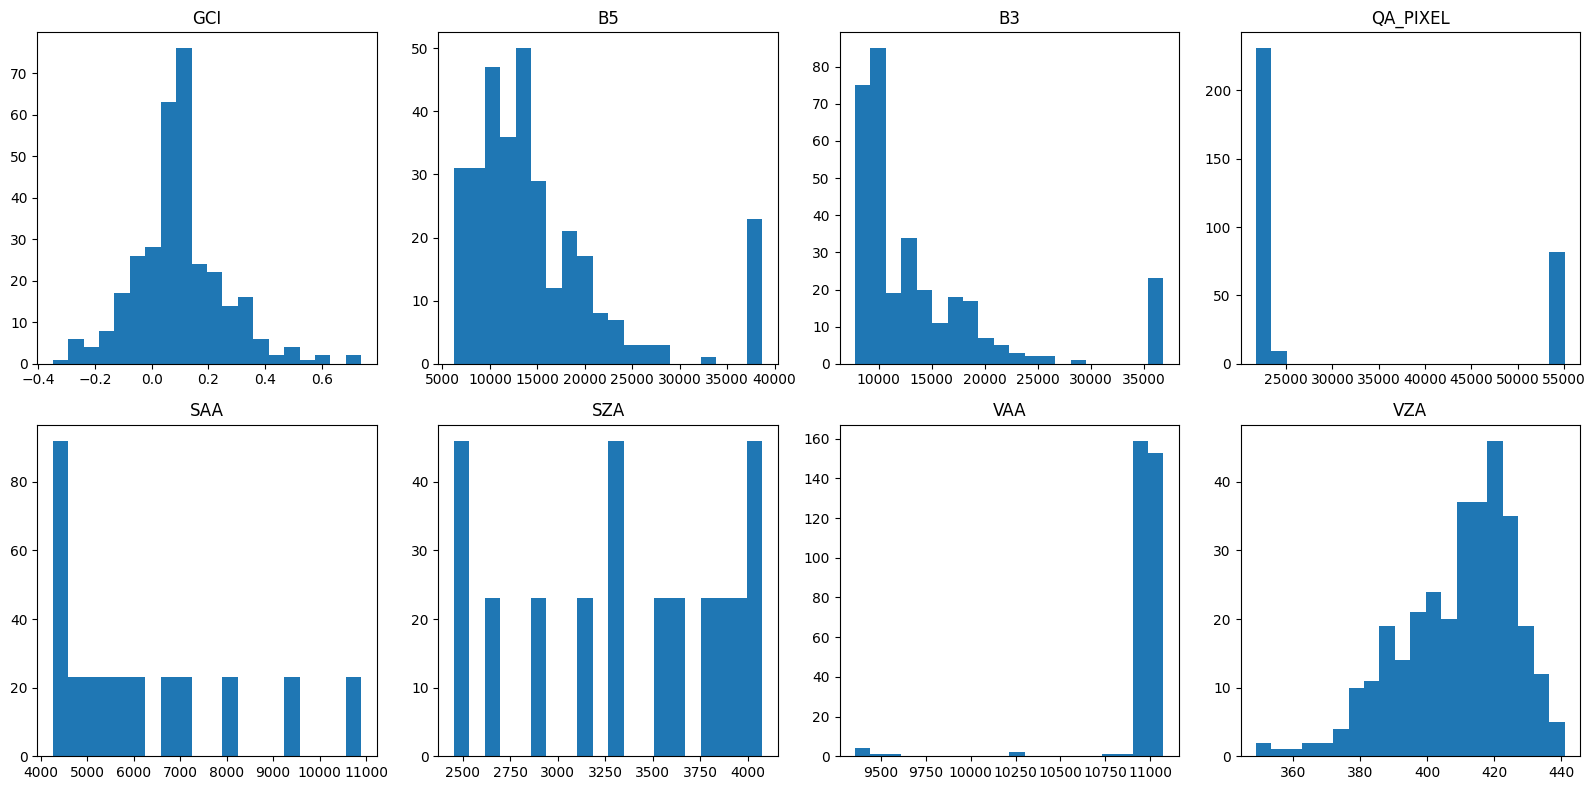

In [27]:
import matplotlib.pyplot as plt

# Assuming df_full contains the DataFrame with the columns you mentioned
selected_columns = ['GCI','B5', 'B3','QA_PIXEL', 'SAA', 'SZA', 'VAA', 'VZA']

# Create subplots for each column
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, col in enumerate(selected_columns):
    row = i // 4
    col_num = i % 4
    ax = axes[row, col_num]

    # Plot a histogram for each selected column
    ax.hist(df[col], bins=20)  # Adjust the number of bins as needed
    ax.set_title(col)

# Adjust layout
plt.tight_layout()
plt.savefig('subplots_sebaran_data_before.png', bbox_inches='tight')
plt.show()


##NORMALISASI SEMUA KOLOM MENJADI RANGE 0 sampai 1

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler dengan rentang 0 hingga 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Menormalisasi semua kolom dalam DataFrame
df_normalized = df.copy()  # Membuat salinan DataFrame
df_normalized[df.columns] = scaler.fit_transform(df_normalized)

In [29]:
df_normalized

,GCI,B5,B3,QA_PIXEL,SAA,SZA,VAA,VZA
0,0.403299,0.096450,0.027312,0.005707,0.389792,0.413538,0.942957,0.750000
1,0.371603,0.148782,0.092394,1.000000,0.229298,0.518769,0.932480,0.836957
2,0.478608,0.108356,0.018059,0.005707,0.109455,0.665231,0.954598,0.641304
3,0.367407,0.980033,0.978535,1.000000,0.035080,0.818462,0.944703,0.728261
4,0.405620,0.283719,0.218328,0.015560,0.000903,0.939692,0.940629,0.782609
...,...,...,...,...,...,...,...,...
317,0.382982,0.397274,0.348457,0.015560,0.262873,0.519385,0.954598,0.663043
318,0.216999,0.116909,0.120464,0.063863,0.401536,0.294769,0.931898,0.869565
319,0.498520,0.234494,0.131058,0.015560,0.581150,0.104615,0.944703,0.750000
320,0.515119,0.312638,0.197241,0.009552,0.793436,0.001846,0.945867,0.728261


## Melihat ringkasan statistik dari dataset yang sudah dinormalisasi

In [30]:
df_normalized.describe()

,GCI,B5,B3,QA_PIXEL,SAA,SZA,VAA,VZA
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,0.410090,0.278869,0.213816,0.261831,0.290964,0.564499,0.933214,0.651870
std,0.146766,0.243043,0.254984,0.432275,0.300672,0.343972,0.130527,0.183994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.341366,0.124962,0.052423,0.001862,0.035080,0.295385,0.938300,0.532609
50%,0.403600,0.215497,0.101476,0.015560,0.194068,0.591692,0.948778,0.690217
75%,0.473160,0.355864,0.286789,1.000000,0.401197,0.895385,0.965949,0.782609
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## MELIHAT DISTRIBUSI DATA SETELAH DINORMALISASI

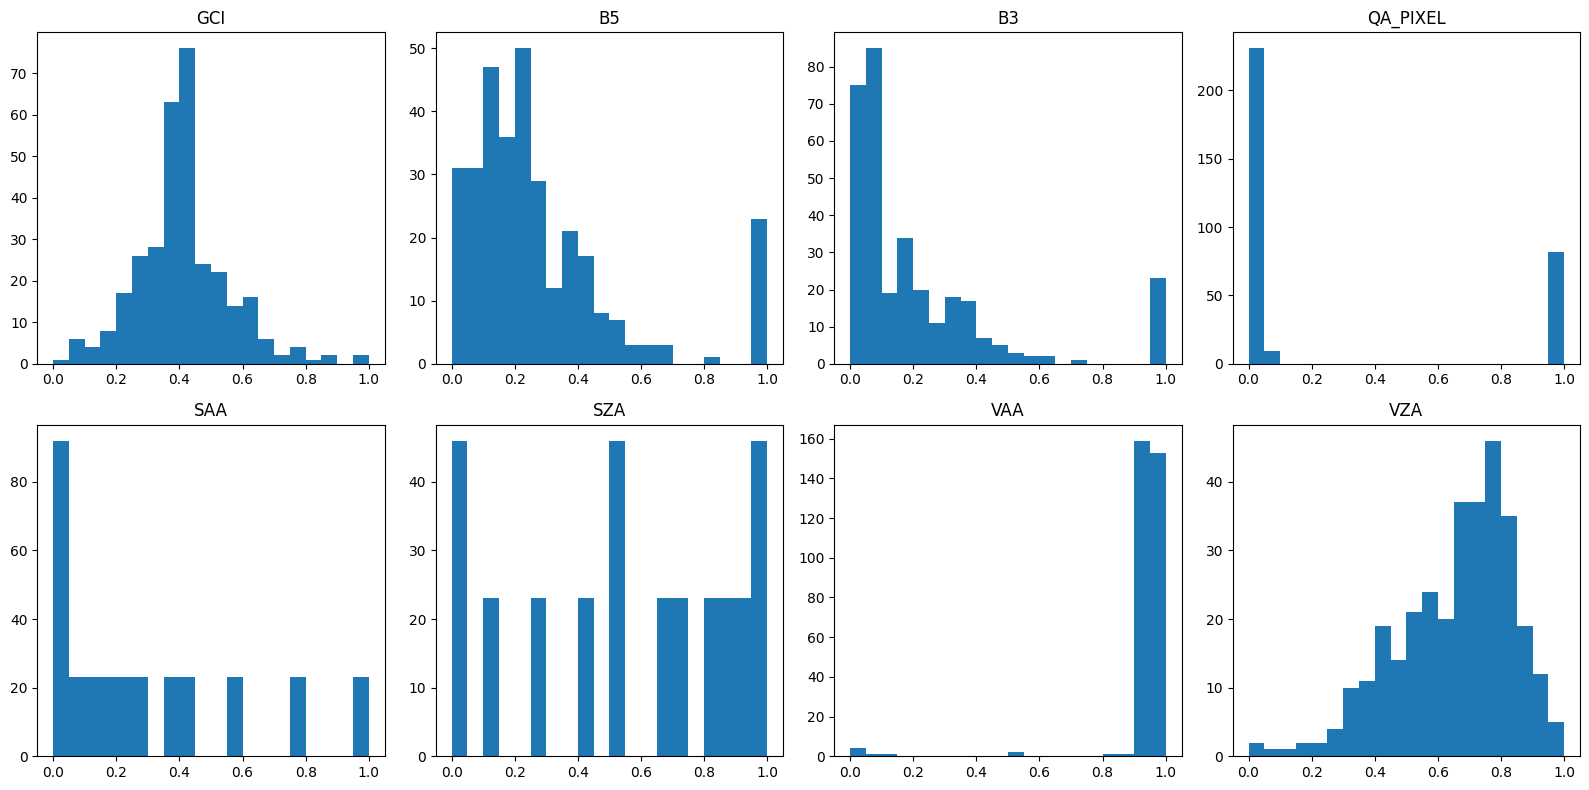

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, col in enumerate(selected_columns):
    row = i // 4
    col_num = i % 4
    ax = axes[row, col_num]

    # Plot a histogram for each selected column
    ax.hist(df_normalized[col], bins=20)  # Adjust the number of bins as needed
    ax.set_title(col)

# Adjust layout
plt.tight_layout()
# Save the figure to a file
plt.savefig('subplots_sebaran_data_after.png', bbox_inches='tight')
plt.show()

## Melihat matriks korelasi antar kolom

In [32]:
correlation_matrix = df_normalized.corr()
print(correlation_matrix)

               GCI        B5        B3  QA_PIXEL       SAA       SZA  \
GCI       1.000000  0.123342 -0.069842 -0.094870  0.057542 -0.047864   
B5        0.123342  1.000000  0.980674  0.495174 -0.308447  0.286024   
B3       -0.069842  0.980674  1.000000  0.521057 -0.322187  0.297199   
QA_PIXEL -0.094870  0.495174  0.521057  1.000000 -0.341257  0.294140   
SAA       0.057542 -0.308447 -0.322187 -0.341257  1.000000 -0.946658   
SZA      -0.047864  0.286024  0.297199  0.294140 -0.946658  1.000000   
VAA       0.061644  0.019055  0.004845 -0.185119  0.110810 -0.141474   
VZA       0.151009  0.032751 -0.001373 -0.115105  0.210295 -0.263748   

               VAA       VZA  
GCI       0.061644  0.151009  
B5        0.019055  0.032751  
B3        0.004845 -0.001373  
QA_PIXEL -0.185119 -0.115105  
SAA       0.110810  0.210295  
SZA      -0.141474 -0.263748  
VAA       1.000000  0.330603  
VZA       0.330603  1.000000  


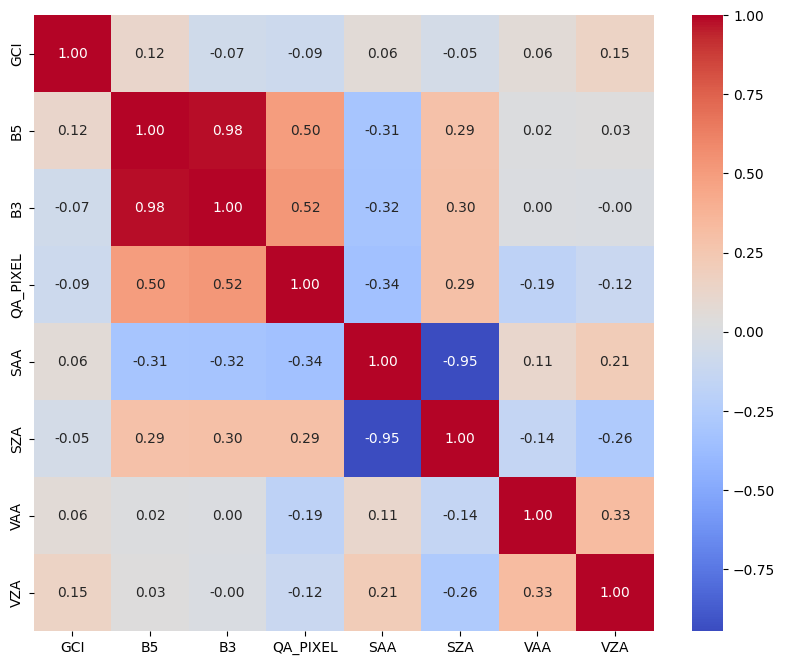

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# Save the image to a file (e.g., PNG format)
plt.savefig('correlation_heatmap.png', bbox_inches='tight')
plt.show()

#Add DateTime to dataframe

In [34]:
df_normalized['DateTime'] = pd.Series(time, index=df_normalized.index)

In [35]:
df_normalized

,GCI,B5,B3,QA_PIXEL,SAA,SZA,VAA,VZA,DateTime
0,0.403299,0.096450,0.027312,0.005707,0.389792,0.413538,0.942957,0.750000,2022-04-04 03:00:01.712
1,0.371603,0.148782,0.092394,1.000000,0.229298,0.518769,0.932480,0.836957,2022-04-20 02:59:51.792
2,0.478608,0.108356,0.018059,0.005707,0.109455,0.665231,0.954598,0.641304,2022-05-06 02:59:47.333
3,0.367407,0.980033,0.978535,1.000000,0.035080,0.818462,0.944703,0.728261,2022-05-22 02:59:35.905
4,0.405620,0.283719,0.218328,0.015560,0.000903,0.939692,0.940629,0.782609,2022-06-07 02:59:37.422
...,...,...,...,...,...,...,...,...,...
317,0.382982,0.397274,0.348457,0.015560,0.262873,0.519385,0.954598,0.663043,2022-08-26 03:00:19.284
318,0.216999,0.116909,0.120464,0.063863,0.401536,0.294769,0.931898,0.869565,2022-09-11 03:00:20.065
319,0.498520,0.234494,0.131058,0.015560,0.581150,0.104615,0.944703,0.750000,2022-09-27 03:00:26.773
320,0.515119,0.312638,0.197241,0.009552,0.793436,0.001846,0.945867,0.728261,2022-10-13 03:00:30.536


# Menambahkan label dan class berdasarkan range nilai GCI

In [43]:
df_normalized.loc[(df_normalized['GCI'] <= 0.05), 'Class'] = 1
df_normalized.loc[(df_normalized['GCI'] > 0.05) & (df_normalized['GCI'] <= 0.20), 'Class'] = 2
df_normalized.loc[(df_normalized['GCI'] > 0.20) & (df_normalized['GCI'] <= 0.60), 'Class'] = 3
df_normalized.loc[(df_normalized['GCI'] > 0.60) & (df_normalized['GCI'] <= 0.80), 'Class'] = 4
df_normalized.loc[(df_normalized['GCI'] > 0.80) & (df_normalized['GCI'] <= 1.00), 'Class'] = 5

df_normalized.loc[(df_normalized['GCI'] <= 0.20), 'Label'] = 'No Mangrove'
df_normalized.loc[(df_normalized['GCI'] > 0.20) & (df_normalized['GCI'] <= 0.40), 'Label'] = 'Bad'
df_normalized.loc[(df_normalized['GCI'] > 0.40) & (df_normalized['GCI'] <= 0.60), 'Label'] = 'Normal'
df_normalized.loc[(df_normalized['GCI'] > 0.60) & (df_normalized['GCI'] <= 0.80), 'Label'] = 'Good'
df_normalized.loc[(df_normalized['GCI'] > 0.80) & (df_normalized['GCI'] <= 1.00), 'Label'] = 'Very Good'

# Print the updated DataFrame
print(df_normalized)


          GCI        B5        B3  QA_PIXEL       SAA       SZA       VAA  \
0    0.403299  0.096450  0.027312  0.005707  0.389792  0.413538  0.942957   
1    0.371603  0.148782  0.092394  1.000000  0.229298  0.518769  0.932480   
2    0.478608  0.108356  0.018059  0.005707  0.109455  0.665231  0.954598   
3    0.367407  0.980033  0.978535  1.000000  0.035080  0.818462  0.944703   
4    0.405620  0.283719  0.218328  0.015560  0.000903  0.939692  0.940629   
..        ...       ...       ...       ...       ...       ...       ...   
317  0.382982  0.397274  0.348457  0.015560  0.262873  0.519385  0.954598   
318  0.216999  0.116909  0.120464  0.063863  0.401536  0.294769  0.931898   
319  0.498520  0.234494  0.131058  0.015560  0.581150  0.104615  0.944703   
320  0.515119  0.312638  0.197241  0.009552  0.793436  0.001846  0.945867   
321  0.393504  0.135337  0.070517  0.005707  1.000000  0.015385  0.939464   

          VZA                DateTime  Class   Label  
0    0.750000 2022-0

In [45]:
df_normalized.to_excel('df_normalized.xlsx', index=False)

#Mengambil variabel yang dibutuhkan untuk training (X dan y)

In [46]:
X = df_normalized[['B5','B3','QA_PIXEL','SAA','SZA','VAA','VZA']]  # Features
y = df_normalized['Class']  # Target variable

#Split data to train and test

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(225, 7)
(225,)
(97, 7)
(97,)


##Train random forest

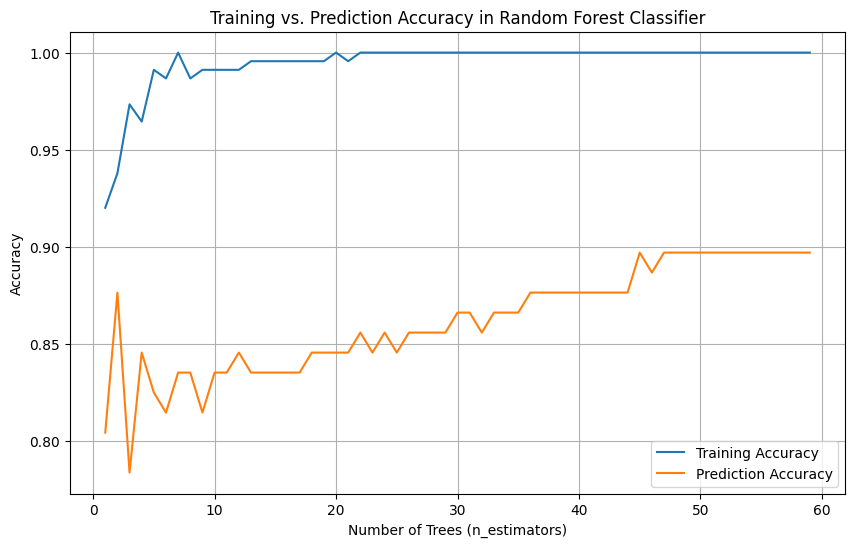

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest Classifier
clf = RandomForestClassifier(random_state=12)  # You can specify other hyperparameters as needed

# Initialize empty lists to store training and prediction accuracy
train_accuracy_list = []
pred_accuracy_list = []

# Train the classifier on the training data and record accuracy at each stage
for n_estimators in range(1, 60):  # You can adjust the range as needed
    clf.n_estimators = n_estimators
    clf.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracy_list.append(train_accuracy)

    # Prediction accuracy
    y_pred = clf.predict(X_test)  # Make predictions on a test/validation set
    pred_accuracy = accuracy_score(y_test, y_pred)
    pred_accuracy_list.append(pred_accuracy)

# Create a line chart to visualize the learning progress
x = np.arange(1, 60)  # Number of trees (n_estimators)
plt.figure(figsize=(10, 6))
plt.plot(x, train_accuracy_list, label='Training Accuracy')
plt.plot(x, pred_accuracy_list, label='Prediction Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Prediction Accuracy in Random Forest Classifier')
plt.grid(True)
# Save the figure to a file
plt.savefig('random_forest_accuracy_plot.png', bbox_inches='tight')
plt.show()


#Prediciton

In [66]:
# Make predictions on the test data
y_pred = clf.predict(X_test)

#Melihat kualitas hasil segmentasi dengan statistikal analisis (Evaluasi Model)

In [67]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa_score = cohen_kappa_score(y_test, y_pred)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Cohen's Kappa Score: 0.6146205800556217
Accuracy: 0.8969072164948454
Precision: 0.8844744323046887
Recall: 0.8969072164948454
F1-Score: 0.8831357847731407


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


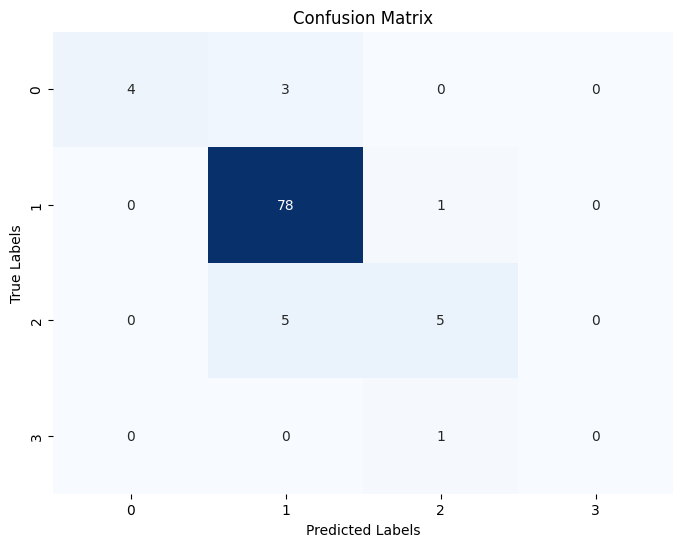

In [68]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
# Save the figure to a file
plt.savefig('confusion_matrix_heatmap.png', bbox_inches='tight')
plt.show()

In [69]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test))
r2 = r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("Mean Squared Error:", mse)

R-squared (R2) Score: 0.517892644135189
Mean Absolute Error: 0.10309278350515463
Root Mean Squared Error: 0.32108064953396775
Mean Absolute Percentage Error: 0.033848797250859104
Mean Squared Error: 0.10309278350515463


#Hasil klasifikasi atau segmentasi lahan mangrove (Gabungan/ 6 Bulan)

In [70]:
class_unique_counts = df_normalized.groupby('Class')['GCI'].nunique()
total_unique_values = class_unique_counts.sum()
class_percentages = (class_unique_counts / total_unique_values) * 100

# Create a dictionary of class labels and descriptions
class_labels = {
    1: 'No Mangrove',
    2: 'Bad',
    3: 'Normal',
    4: 'Good',
    5: 'Very Good'
}

label_GCI = df_normalized['Class']

print("Class Unique Value Percentages:")
for class_label, percentage in class_percentages.items():
    class_description = class_labels.get(class_label, f'Unknown Class {class_label}')
    print(f"{class_description}: {percentage:.2f}%")

Class Unique Value Percentages:
No Mangrove: 0.31%
Bad: 5.59%
Normal: 83.85%
Good: 8.70%
Very Good: 1.55%


# Melihat klasifikasi perbulan menggunakan barplot

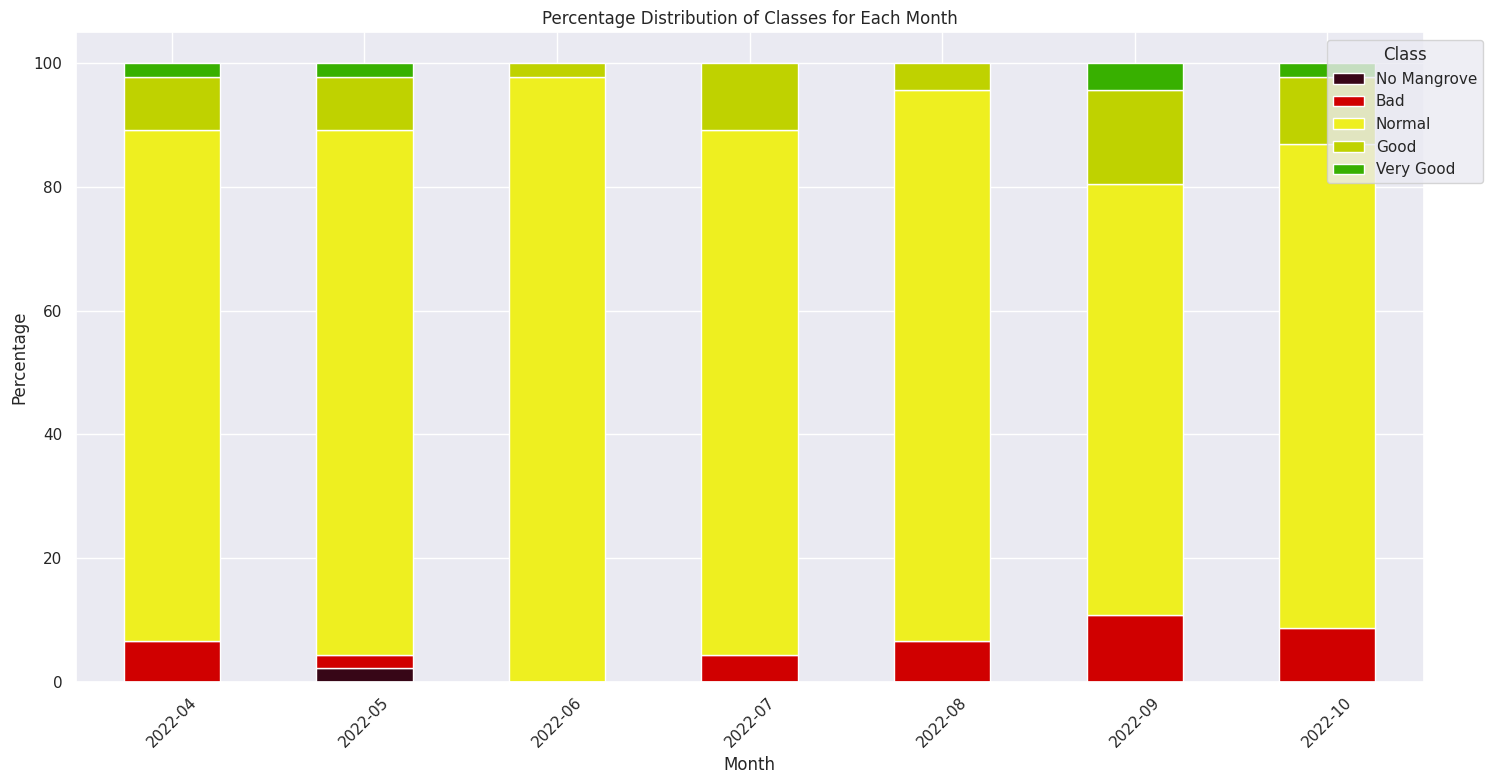

In [71]:
# Convert 'DateTime' column to datetime type
df_normalized['DateTime'] = pd.to_datetime(df_normalized['DateTime'])

# Extract month and year from 'DateTime'
df_normalized['Month'] = df_normalized['DateTime'].dt.strftime('%Y-%m')

# Calculate the percentage distribution of classes for each month
class_distribution = df_normalized.groupby(['Month', 'Class'])['GCI'].count().unstack(fill_value=0)
class_percentages = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100

# Create a custom colormap using ListedColormap
custom_colors = ['#370617', '#d00000', '#eeef20', '#bfd200', '#38b000']
custom_cmap = ListedColormap(custom_colors)

# Create a stacked bar plot
sns.set(rc={'figure.figsize': (15, 8)})
class_percentages.plot(kind='bar', stacked=True, cmap=custom_cmap)
plt.title('Percentage Distribution of Classes for Each Month')
plt.xlabel('Month')
plt.ylabel('Percentage')

legend_labels = [class_labels.get(class_label, f'Class {class_label}') for class_label in class_percentages.columns]
plt.legend(title='Class', loc='upper right', bbox_to_anchor=(1.05, 1), labels=legend_labels)

plt.xticks(rotation=45)
plt.tight_layout()
# Save the figure to a file
plt.savefig('class_distribution_plot.png', bbox_inches='tight')
plt.show()

In [72]:
# Calculate the percentage distribution of classes for each month
class_distribution = df_normalized.groupby(['Month', 'Class'])['GCI'].count().unstack(fill_value=0)
class_percentages = class_distribution.div(class_distribution.sum(axis=1), axis=0) * 100

# Format the percentages to include the percent symbol
class_percentages_formatted = class_percentages.applymap(lambda x: f'{x:.2f}%')

# Print class percentages as a table with percent symbols
print("Percentage Distribution of Classes for Each Month:")
print(class_percentages_formatted.to_string())

Percentage Distribution of Classes for Each Month:
Class      1.0     2.0     3.0     4.0    5.0
Month                                        
2022-04  0.00%   6.52%  82.61%   8.70%  2.17%
2022-05  2.17%   2.17%  84.78%   8.70%  2.17%
2022-06  0.00%   0.00%  97.83%   2.17%  0.00%
2022-07  0.00%   4.35%  84.78%  10.87%  0.00%
2022-08  0.00%   6.52%  89.13%   4.35%  0.00%
2022-09  0.00%  10.87%  69.57%  15.22%  4.35%
2022-10  0.00%   8.70%  78.26%  10.87%  2.17%


# Melihat jenis sebaran data hasil klasifikasi menggunakan scatterplot

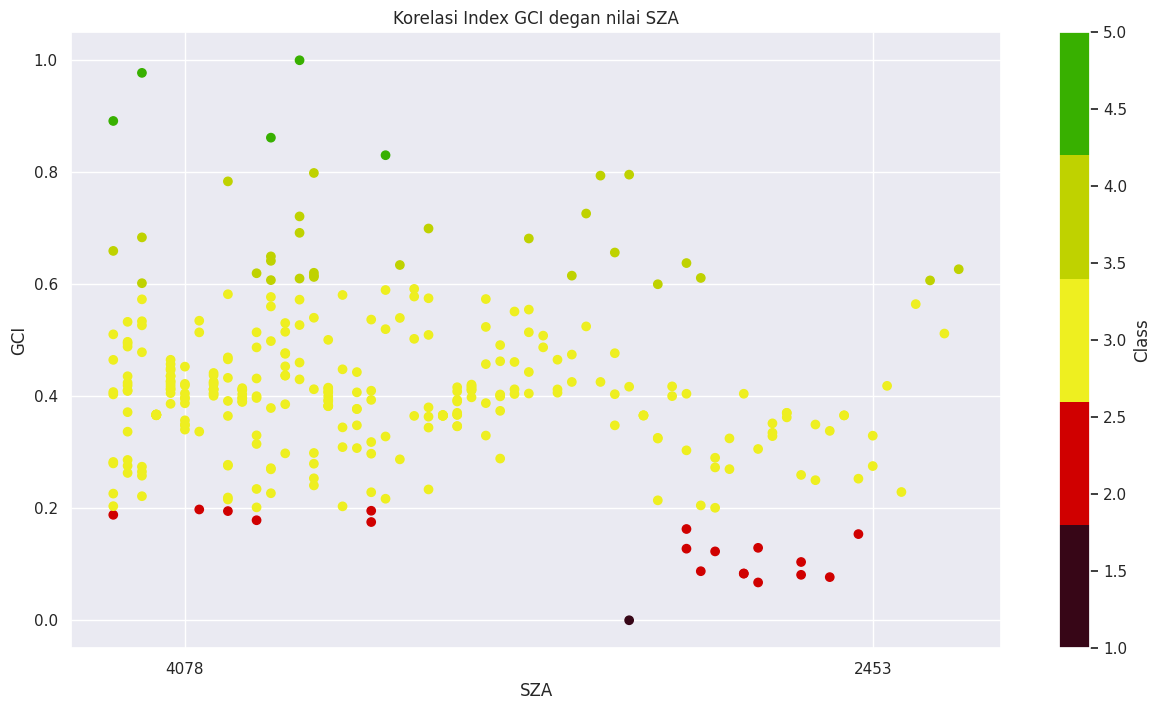

In [73]:
x = df_full['SZA']
y = df_normalized['GCI']
c = df_normalized['Class']  # The variable to map colors based on

# Create a custom colormap using ListedColormap
custom_colors = ['#370617', '#d00000', '#eeef20', '#bfd200', '#38b000']
custom_cmap = ListedColormap(custom_colors)

sc = plt.scatter(x, y, c=c, cmap=custom_cmap)  # Use 'c' and specify a colormap
plt.colorbar(sc, label='Class')  # Add colorbar with label
plt.title('Korelasi Index GCI degan nilai SZA')
plt.xlabel('SZA')
plt.ylabel('GCI')

# Calculate the minimum and maximum values of the 'SZA' column
sza_min = x.min()
sza_max = x.max()

# Set custom range of x-axis tick labels
custom_range = [sza_min, sza_max]
plt.xticks(custom_range)  # Set custom tick values
# Save the figure to a file
plt.savefig('scatter_plot.png', bbox_inches='tight')
plt.show()
